In [1]:
import torch_geometric as tg #PyTorch Geometric
import torch as th #PyTorch 2.0
from torch import nn #Neural network module
from torchvision.transforms import ToTensor, Compose, Normalize #Used for MNIST preprocessing
from torchvision.datasets import MNIST #MNIST dataset
import matplotlib.pyplot as plt #Plotting
import time #keep track of runtime

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')
# ^^^ pytorch geometric is throwing a warning that we can safely ignore

In [3]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu') #Check whether a GPU is available
print('Device: {}'.format(device)) #Print out the device we're using

Device: cuda


In [4]:
MNIST_PATH = './data/mnist' #Path to where the MNIST dataset will be downloaded, feel free to change this
mu, sigma = 0.1307, 0.3081 #Mean and standard deviation of the MNIST dataset, used for normalization. Usually we'd calculate this from the dataset itself, but we already know these values.
mnist_train = MNIST(MNIST_PATH, download=True, transform=Compose([ToTensor(), Normalize((mu,), (sigma,))])) #Load the MNIST dataset, standardize and download it if necessary.
mnist_test = MNIST(MNIST_PATH, download=True, train=False, transform=Compose([ToTensor(), Normalize((mu,), (sigma,))])) #Same for the test split

In [5]:
bs = 128 #Batch size (should be the largest multiple of 8 that fits in VRAM, you can check VRAM usage with nvidia-smi in the terminal). This fits on a 2080Ti with 11GB VRAM.
k = 24 #Number of nearest neighbors to consider. K = 24 is equivalent to 2 hops on a regular grid.
scale = 2 #Downscaling factor for the images. We downscale the images to 14x14 pixels, to speed up training and reduce memory usage.

pix_shuffle = nn.PixelUnshuffle(scale) #Used to downscale the images by moving pixels to the channels dimension: (Channels, Height, Width) -> (Channels*scale^2, Height//scale, Width//scale)
(row, col), pos = tg.utils.grid(28 // scale, 28 // scale) #Get the positions of the pixels in the downsampled image, we need them for KNN computation.

In [6]:
transforms = tg.transforms.Compose([
    tg.transforms.KNNGraph(k=k), #Create kNN graph based on pixel coordinates
    tg.transforms.AddSelfLoops(), #Add self loops to the graph, connect every node to itself (i.e. the pixel at position (i, j) is connected to itself).
    tg.transforms.LocalCartesian(), #Compute pseudo-coordinates for each node to add as edge attributes. This makes the model more aware of the input data geometry.
    tg.transforms.NormalizeScale(), #Normalize node positions (only necessary if we want to use position information as a feature)
    ])

#Create a list of Data objects, one for each image in the dataset. This is very slow, but good enough for this tutorial.
#Images are downscaled, shuffled and the resulting Data objects are transformed according to the transforms defined above.
train_list = [transforms(tg.data.Data(x = (pix_shuffle(img)).view(scale**2, -1).t(), pos = pos, y = label)) for img, label in mnist_train]
test_list = [transforms(tg.data.Data(x = (pix_shuffle(img)).view(scale**2, -1).t(), pos = pos, y = label)) for img, label in mnist_test]


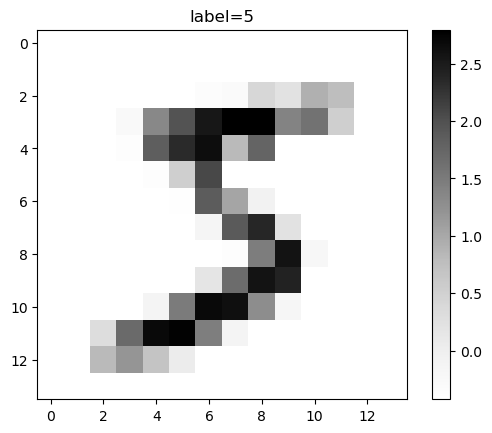

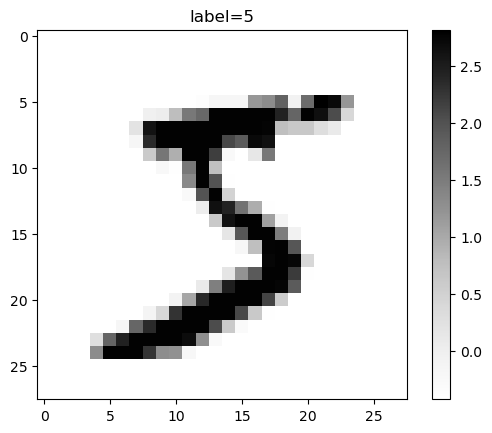

In [7]:
#Always plot one sample as a sanity check.
#Here we can also compare the downsampled image to the original image.
x = mnist_train[0][0]
plt.imshow(pix_shuffle(x).mean(0), cmap= 'Greys') #Downscale the image and plot the mean over the channels dimension
plt.colorbar() #This is especially important to check whether the value range of the image makes sense (i.e. somewhat standard-normal distributed)
plt.title(f'label={mnist_train[0][1]}')
plt.show()

plt.imshow(x.squeeze(), cmap='Greys') #Squeeze removes all dimensions with length 1, in this case the channels dimension. This is the original image.
plt.colorbar() #This is especially important to check whether the value range of the image makes sense (i.e. somewhat standard-normal distributed)
plt.title(f'label={mnist_train[0][1]}')
plt.show()

In [8]:
#Create data loaders for the training and test set. Num_workers > 0 will enable multi-process data loading and speeds up training (you can check this with nvidia-smi and note the GPU-Util%).
dl = tg.loader.DataLoader(train_list, batch_size=bs, shuffle=True, num_workers=4)
test_dl = tg.loader.DataLoader(test_list, batch_size=bs, shuffle=False, num_workers=4)

In [9]:
class EdgeModel(nn.Module):
    '''
    Implements an MLP that maps the source, destination, edge attributes, and global attributes to new edge attributes.
    '''
    def __init__(self, node_dim: int, edge_dim: int, global_dim: int, r: int = 2):
        '''
        node_dim: dimension of node attributes
        edge_dim: dimension of edge attributes
        global_dim: dimension of global attributes
        r: expansion factor for MLP
        '''
        super().__init__()
        #The input dimension is the sum of the dimensions of the source, destination, edge, and global attributes
        dim = node_dim + node_dim + edge_dim + global_dim
        #Below is a fairly modern MLP implementation with LayerNorm, channel expansion and GELU activation. Feel free to experiment with it. 
        self.edge_mlp = nn.Sequential( 
            tg.nn.LayerNorm(dim), #LayerNorm normalizes the input features to have mean 0 and variance 1 across the whole graph. This is supposed to improve training stability.
            nn.Linear(dim, dim * r), 
            nn.GELU(), #GELU is a slightly modified ReLU that is supposed to perform better because it is less likely to have a vanishing gradient.
            nn.Linear(dim * r, edge_dim)
        )
    def forward(self, src, dst, edge_attr, u, batch):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        out = th.cat([src, dst, edge_attr, u[batch]], 1) #Concatenate the source node attributes, destination node attributes, edge attributes, and global attributes
        out = self.edge_mlp(out) + edge_attr #Apply the MLP and add the result to the edge attributes. The addition is a residual connection and improves training.
        return out

class NodeModel(nn.Module):
    '''
    Implements an MLP that maps the node attributes, edge attributes, and global attributes to new node attributes.
    '''
    def __init__(self, node_dim: int, edge_dim: int, global_dim: int, r: int = 2):
        '''
        node_dim: dimension of node attributes
        edge_dim: dimension of edge attributes
        global_dim: dimension of global attributes
        r: expansion factor for MLP
        '''
        super().__init__()
        #The input dimension is the sum of the dimensions of the node, edge, and global attributes
        dim_1 = node_dim + edge_dim
        #The input dimension for the second MLP is the sum of the dimensions of the node, edge, and global attributes, plus the output dimension of the first MLP
        dim_2 = node_dim + dim_1 + global_dim
        #Same as above
        self.node_mlp_1 = nn.Sequential(
            tg.nn.LayerNorm(dim_1),
            nn.Linear(dim_1, dim_1 * r),
            nn.GELU(),
            nn.Linear(dim_1 * r, dim_1)
        )
        #Same as above
        self.node_mlp_2 = nn.Sequential(
            tg.nn.LayerNorm(dim_2),
            nn.Linear(dim_2, dim_2 * r),
            nn.GELU(),
            nn.Linear(dim_2 * r, node_dim)
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index #Get the source and destination indices from the adjacency
        out = th.cat([x[row], edge_attr], dim=1) #Concatenate the source node attributes and the edge attributes
        out = self.node_mlp_1(out) #Apply the first MLP
        out = tg.utils.scatter(out, col, dim=0, dim_size=x.size(0),
                      reduce='mean') #Aggregate the edge attributes for each destination node
        out = th.cat([x, out, u[batch]], dim=1) if u is not None else th.cat([x, out], dim=1) #Concatenate the node attributes, aggregated edge attributes, and global attributes
        out = self.node_mlp_2(out) + x #Apply the second MLP and add the result to the node attributes. The addition is a residual connection and improves training.
        return out

class GlobalModel(th.nn.Module):
    '''
    Implements an MLP that maps the node attributes, edge attributes, and global attributes to new global attributes.
    '''
    def __init__(self, node_dim: int, edge_dim: int, global_dim: int, r: int = 2):
        '''
        node_dim: dimension of node attributes
        edge_dim: dimension of edge attributes
        global_dim: dimension of global attributes
        r: expansion factor for MLP
        '''
        super().__init__()
        #The input dimension is the sum of the dimensions of the node, edge, and global attributes
        dim = node_dim + global_dim
        #Same as above
        self.global_mlp = nn.Sequential(
            tg.nn.LayerNorm(dim), 
            nn.Linear(dim, dim * r),
            nn.GELU(),
            nn.Linear(dim * r, global_dim)
        )
    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        x_hat = tg.utils.scatter(x, batch, dim=0, reduce='mean') #Aggregate all node attributes for each graph
        out = th.cat([u, x_hat], dim=1) #Concatenate the global attributes and the aggregated node attributes
        out = self.global_mlp(out) + u #Apply the MLP and add the result to the global attributes. The addition is a residual connection and improves training.
        return out
    
class GNN_Classifier(nn.Module):
    '''
    Implements an Encode-Process-Decode GNN Classifier for images represented as a graph.
    Based on Battaglia et al. (2018) https://arxiv.org/abs/1806.01261
    The model is composed of the following components:
        - Linear Node and edge embedding layers that map the input to the desired dimensions. (Encode)

        - A number of GNN blocks that process the graph. (Process)
            The GNN blocks essentially consist of MLPs that nonlinearly transform the node, edge, and global attributes.
            MLPs are a sequence of linear layers with a nonlinear activation function in between and are a standard component of neural networks.
            In that sense, these types of GNNs are just MLPs that aggregate information across neighboring nodes and edges, making them conceptually very simple.
            Because MLPs are universal function approximators, these GNNs can learn to approximate any function of the input graph.

        - A linear layer that maps the global attribute to the target classes. (Decode)
            This is a simple linear classifier! Note that the GlobalModel MLP performs a nonlinear transformation of the global attribute before it is fed to the linear classifier.
            The nonlinear transformation changes the representation of the global attribute to make it easy for the linear classifier to separate the classes.
    '''
    def __init__(self, node_input: int, node_dim: int, edge_input: int, edge_dim: int, global_dim: int, output_dim: int, depth: int):
        '''
        node_input: dimension of node input
        node_dim: dimension of node attributes
        edge_input: dimension of edge input
        edge_dim: dimension of edge attributes
        global_dim: dimension of global attribute
        output_dim: dimension of output
        depth: number of GNN layers
        '''
        super().__init__()
        self.node_embedding = nn.Linear(node_input, node_dim) # node embedding maps node input to node_dim. 
        self.edge_embedding = nn.Linear(edge_input, edge_dim) # edge embedding maps edge input to edge_dim.
        self.class_predictor = nn.Linear(global_dim, output_dim) # Class predictor maps the global attribute to output_dim.

        self.blocks = nn.ModuleList([tg.nn.MetaLayer( # MetaLayer is a PyTorch Geometric module to implement GNNs as in Battaglia et al. (2018).
            edge_model = EdgeModel(node_dim=node_dim, edge_dim=edge_dim, global_dim=global_dim), # edge model maps src, dst, edge_attr, u to new edge_attr
            node_model = NodeModel(node_dim=node_dim, edge_dim=edge_dim, global_dim=global_dim), # node model maps x, edge_index, edge_attr, u to new x
            global_model = GlobalModel(node_dim=node_dim, edge_dim=edge_dim, global_dim=global_dim) # global model maps x, edge_index, edge_attr, u to new u
        )                                    for _ in range(depth)])

        self.class_token = nn.Parameter(th.randn(1, global_dim)) # class token is a learnable parameter representing the initial global attribute. Could be zeros instead.

    def forward(self, data):
        '''
        data: a batch of graphs containing the following attributes
            x: [Nodes, node_input] containing pixel values
            edge_attr: [Edges, edge_input] containing relative positions
            edge_index: [2, Edges] containing graph connectivity
            batch: [Nodes] with max entry Batch - 1
            num_graphs: number of graphs in the batch
        '''
        #Encode the initial attributes
        edge_index = data.edge_index # [2, Edges]
        #The class token is the same for all graphs in the batch, hence the expand. Expand does not allocate new memory, which is important for performance
        u = self.class_token.expand(data.num_graphs, -1) # [Batch, F_u]. 
        x = self.node_embedding(data.x) # [Nodes, F_x]
        edge_attr = self.edge_embedding(data.edge_attr) # [Edges, F_e]
        #Process the graph with GNN blocks
        for block in self.blocks:
            x, edge_attr, u = block(x=x, edge_index=edge_index, edge_attr=edge_attr, u=u, batch=data.batch) # [Nodes, F_x], [Edges, F_e], [Batch, F_u]
        #Decode the class label from the global attribute. Instead of using the class token, we could also use the global mean of the node attributes x. Feel free to experiment with this.
        label = self.class_predictor(u) # [Batch, output_dim]
        return label

In [10]:
#Define the model. Feel free to experiment with the hyperparameters.
model = GNN_Classifier(node_input = 4, node_dim = 16, edge_input = 2, edge_dim = 16, global_dim = 16, output_dim = 10, depth = 4)
#edge_input = 2 because the edge attributes are the relative positions of the nodes, which are 2-dimensional
#node_input = 4 because the node attributes are the pixel values, which are 4-dimensional after the downsampling
#output_dim = 10 because there are 10 classes in MNIST

#global_dim, node_dim and edge_dim are chosen rather arbitrarily. On GPUs multiple of 8 are usually faster to compute, but this is not a hard rule.

#Depth is the number of GNN blocks, i.e. the number of times the graph is processed. This implicitly defines the receptive field of the model.
#Because each GNN block aggregates information from neighboring nodes and edges, consecutive GNN blocks access information from further and further away nodes.
#The receptive field is the number of hops a node can make to reach another node. In this case, the receptive field depends on k and depth. 
#On a grid and with k = 24 each Graph-layer can look 2 hops in each direction, so the receptive field is 2 * depth.


count_parameters = lambda model: sum(p.numel() for p in model.parameters() if p.requires_grad) #This is a simple lambda function to count the number of trainable parameters in the model
print('Number of parameters: {}'.format(count_parameters(model))) #Print the number of parameters in the model

loss_fn = nn.CrossEntropyLoss() #Cross entropy loss is a standard loss function for multiclass classification
num_epochs = 30 #Number of epochs to train for
optimizer = th.optim.AdamW(model.parameters(), lr = 1e-5) #AdamW is a standard optimizer for neural networks that performs well in practice.
scheduler = th.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 5e-4, steps_per_epoch = len(dl), epochs = num_epochs)
#Learning rate scheduling is a technique to improve the training. It changes the learning rate during training and can improve the final performance.
#OneCycleLR first increases the learning rate, which helps the model converge quickly, and then decreases it, which helps the model to generalize better.
#The learning rate is changed every batch, which is why we need to pass the number of batches per epoch to the scheduler.
#There are many possible learning rate schedules, but I like this one because it is simple and works well in practice.

Number of parameters: 114298


In [11]:
#We will use these lists to keep track of the loss and accuracy during training
loss_tracker, val_loss_tracker, acc_tracker = [] , [], []

model.to(device) #Move the model to the GPU if available
model.train() #Put the model in training mode. This is important because some modules like dropout behave differently in training and evaluation mode.
for epoch in range(num_epochs): #Iterate over the epochs
    t0 = time.time() #Keep track of the time
    for data in dl: #Iterate over the data in the data loader
        data = data.to(device) #Move the data to the GPU if available
        out = model(data) #Forward pass of the model
        loss = loss_fn(out, data.y) #Compute the loss
        optimizer.zero_grad() #Zero out the gradients from the previous iteration, otherwise they would accumulate (PyTorch standard behavior)
        loss.backward() #Backpropagate the loss through the model
        optimizer.step() #Update the parameters
        scheduler.step() #Update the learning rate
        loss_tracker.append(loss.item()) #Add the loss to the loss tracker

    with th.no_grad(): #We don't need gradients for evaluation, so we can turn them off to save memory and compute
        model.eval() #Put the model in evaluation mode. This is important because some modules like dropout behave differently in training and evaluation mode.
        correct = 0 #Keep track of the number of correct predictions
        validation_loss = 0 #Keep track of the loss on the validation set
        for data in test_dl: #Iterate over the test data
            data = data.to(device) #Move the data to the GPU if available
            out = model(data) #Forward pass of the model
            loss = loss_fn(out, data.y) #Compute the loss
            validation_loss += loss.item() #Add the loss to the validation loss 
            pred = out.argmax(dim=1) #Get the predicted class labels
            correct += pred.eq(data.y).sum().item() #Count the number of correct predictions
        acc = correct / len(test_list) #Compute the accuracy for the test set
        acc_tracker.append(acc) #Add the accuracy to the accuracy tracker
        val_loss_tracker.append(validation_loss / len(test_dl)) #Add the validation loss to the validation loss tracker
    #Print the loss and accuracy for this epoch and the time it took to run the epoch. If the loss is not decreasing, consider interrupting the training early.
    print('Epoch: {:03d}, Loss: {:.3f}, Validation Loss: {:.3f}, Acc: {:.3f}, Time: {:.2f} min'.format(epoch, loss_tracker[-1], val_loss_tracker[-1], acc_tracker[-1], (time.time() - t0) / 60))

Epoch: 000, Loss: 2.11, Validation Loss: 2.15, Acc: 0.20, Time: 1.74
Epoch: 001, Loss: 1.80, Validation Loss: 1.88, Acc: 0.28, Time: 1.68
Epoch: 002, Loss: 1.68, Validation Loss: 1.73, Acc: 0.35, Time: 1.68
Epoch: 003, Loss: 1.25, Validation Loss: 1.23, Acc: 0.56, Time: 1.69
Epoch: 004, Loss: 0.84, Validation Loss: 0.74, Acc: 0.75, Time: 1.68
Epoch: 005, Loss: 0.32, Validation Loss: 0.36, Acc: 0.88, Time: 1.67
Epoch: 006, Loss: 0.26, Validation Loss: 0.26, Acc: 0.92, Time: 1.69
Epoch: 007, Loss: 0.08, Validation Loss: 0.18, Acc: 0.94, Time: 1.71
Epoch: 008, Loss: 0.09, Validation Loss: 0.14, Acc: 0.95, Time: 1.70
Epoch: 009, Loss: 0.05, Validation Loss: 0.10, Acc: 0.97, Time: 1.70
Epoch: 010, Loss: 0.09, Validation Loss: 0.10, Acc: 0.97, Time: 1.71
Epoch: 011, Loss: 0.21, Validation Loss: 0.09, Acc: 0.97, Time: 1.71
Epoch: 012, Loss: 0.13, Validation Loss: 0.08, Acc: 0.98, Time: 1.72
Epoch: 013, Loss: 0.08, Validation Loss: 0.10, Acc: 0.97, Time: 1.71
Epoch: 014, Loss: 0.11, Validation

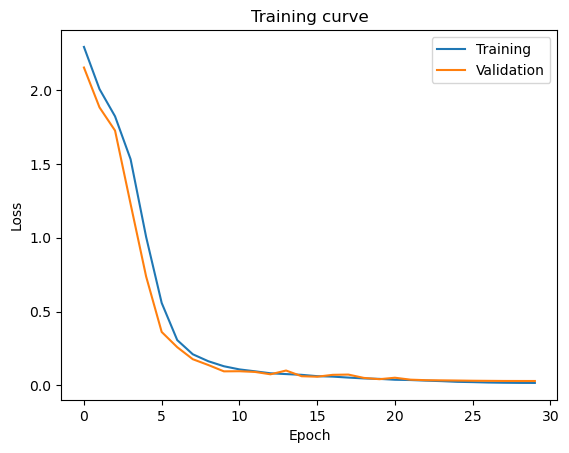

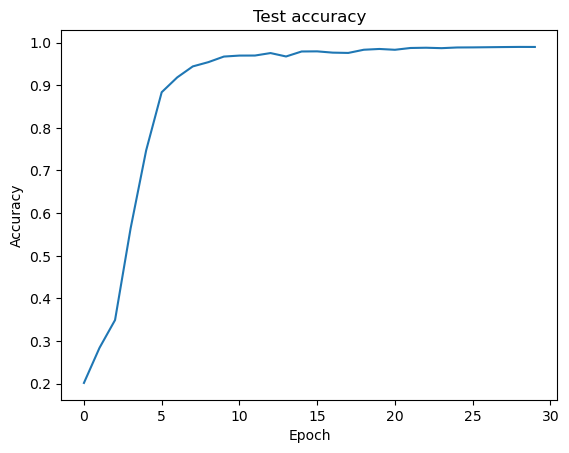

Final test accuracy: 0.9896


In [15]:
epoch_loss = [sum(loss_tracker[len(dl)*i:len(dl)*(i+1)]) / len(dl) for i in range(num_epochs)] #Average the loss per epoch for smoother curves
plt.plot(epoch_loss, label = 'Training') #Plot the loss
plt.plot(val_loss_tracker, label = 'Validation') #Plot the validation loss. If the validation loss is much higher than the training loss, the model is overfitting.
plt.ylabel('Loss') #The absolute value of the loss doesn't matter, only the relative value between different models
plt.xlabel('Epoch') #This would look smoother if we averaged the loss per epoch. Feel free to try this.
plt.title('Training curve') #The loss should decrease over time and converge to a small value. If it doesn't, something is wrong. This plot is an essential sanity check!
plt.legend() #Show the legend
plt.show()

plt.plot(acc_tracker) #Plot the accuracy
plt.ylabel('Accuracy') #Here, the absolute value of the accuracy matters, because it is the final performance of the model on the test set
plt.xlabel('Epoch')
plt.title('Test accuracy') #The accuracy should increase over time and not decrease. If it does, the model is overfitting and we should change something.
plt.show()

print('Final test accuracy: {:.4f}'.format(acc_tracker[-1])) #State of the art on MNIST is 99.8% 

Based on these curves we can say a few things:
- The model does not appear to be overfitting, so we could increase model capacity (i.e. add more channels)
- The model converges before the end of training, so we could train for fewer epochs (but this may change if we train a larger model!)
- The model performs quite well, so our implementation is correct and we can think about improving performance, rather than fixing issues.
